In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from cnmf_e import init_ring_model, init_neurons_ding, update_ring_model_w

In [2]:
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
import scipy
from skimage.external.tifffile import TiffFile
import sys
import time
import logging

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman

## load preprocessed data

In [3]:
data = np.load("cnmfe_init_output.npz")
print(data.files)
U = data['arr_0']
V = data['arr_1']
A = data['arr_2']
X = data['arr_3']
d1, d2, T, r = data['arr_4']
print(d1, d2, r, T)

['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4']
252 304 13 2000


## Verify init_ring_model()

In [4]:
print(U.shape, V.shape, A.shape, X.shape)
U_ax, W = init_ring_model(U, d1, d2, r)
print(U_ax.shape, W.shape)

(76608, 50) (50, 2000) (76608, 200) (200, 50)
(76608, 50) (76608, 76608)


In [5]:
# cor = [0] * 50
# for i in range(50):
#     cor[i] = np.inner(U[:,i], U_ax[:, i]) / np.linalg.norm(U[:, i]) / np.linalg.norm(U_ax[:, i])

In [6]:
video_bef = np.matmul(U, V).reshape(252, 304, -1)
print(video_bef.shape)

(252, 304, 2000)


In [7]:
video_bef = video_bef - np.amin(video_bef)

In [8]:
np.min(video_bef)

0.0

In [9]:
B = W.dot(U - U_ax)
video_after = np.matmul(U - B, V).reshape(252, 304, 2000)

In [10]:
np.savez('init_background.npz', U=U, V=V, U_a=(U-B))

In [11]:
np.amin(video_after)

-133.7442399514418

In [12]:
movie_bef = caiman.movie(video_bef.transpose((2,0,1)))

In [13]:
movie_bef.play(q_max=99.5, fr=30, magnification=4) 

In [14]:
movie_after = caiman.movie(video_after.transpose(2,0,1))

In [15]:
movie_after.play(q_max=99.5, fr=30, magnification=4)

In [16]:
# for i in range(1000, 1003):
#     row = video_bef[:, :, i]
#     im=plt.imshow(row)
#     im.set_data(row)
#     plt.pause(0.02)
# plt.show()

In [17]:
# for i in range(1000, 1003):
#     row = video_after[:, :, i]
#     im=plt.imshow(row)
#     im.set_data(row)
#     plt.pause(0.02)
# #     plt.colorbar()
# plt.show()

## Verify init_neurons_ding() fcn
output a, x, c directly

In [18]:
print(U.shape, U_ax.shape, V.shape, d1, d2)

(76608, 50) (76608, 50) (50, 2000) 252 304


In [20]:
P1 = np.reshape(U - W.dot(U - U_ax), (d1, d2, -1))
P1 = np.reshape(P1, (d1*d2, -1), order='F') # init_neurons() use F order
P2 = np.transpose(V)
P0 = np.reshape(np.matmul(U - W.dot(U - U_ax), V), (d1, d2, T), order='C')
A_ding, X_ding, C_ding = init_neurons_ding(P0, P1, P2, d1, d2, cut_off_point=[0.95, 0.95], length_cut=[10, 10], th=[2, 1], pass_num=1,
                      residual_cut=[0.6, 0.6])

start 1 pass!
find superpixels!
time: 3.87203049659729
rank 1 svd!
time: 5.480708360671997
find pure superpixels!
time: 1.527012586593628
prepare iteration!
0.6931140422821045
time: 6.613901853561401


In [21]:
# A_ding = np.reshape(A_ding, (d1, d2, -1), order='F')
# A_ding = np.reshape(A_ding, (d1*d2, -1))
print(A_ding.shape, X_ding.shape, C_ding.shape)

(76608, 223) (223, 50) (223, 2000)


In [22]:
video_ding = np.matmul(A_ding, C_ding)
video_ding = np.reshape(video_ding, (d1, d2, -1))
print(video_ding.shape)

(252, 304, 2000)


In [23]:
np.amax(video_ding)

96.06496588311552

In [24]:
movie_ding = caiman.movie(video_ding.transpose((2,0,1)))

In [25]:
movie_ding.play(q_max=99.5, fr=30, magnification=4)

In [26]:
# for i in range(1000, 1003):
#     row = video_ding[:, :, i]
#     im=plt.imshow(row)
#     im.set_data(row)
#     plt.pause(0.02)
# #     plt.colorbar()
# plt.show()

In [27]:
video_ding2 = np.matmul(np.matmul(A_ding, X_ding), V)
video_ding2 = np.reshape(video_ding2, (d1, d2, -1))
print(video_ding2.shape)

(252, 304, 2000)


In [28]:
movie_ding2 = caiman.movie(video_ding2.transpose((2,0,1)))

In [29]:
movie_ding2.play(q_max=99.5, fr=30, magnification=4)

In [30]:
# plt.imshow(A_ding[:,10].reshape(d1,d2, order="F"))

In [31]:
print(U.shape, A_ding.shape, X_ding.shape, C_ding.shape, V.shape)

(76608, 50) (76608, 223) (223, 50) (223, 2000) (50, 2000)


In [32]:
print(A.shape)

(76608, 200)


In [33]:
C = np.matmul(X, V)
C2_ding = np.matmul(X_ding, V)
print(C.shape, C2_ding.shape)

(200, 2000) (223, 2000)


In [34]:
corr_A, corr_C, idx = [], [], []
for i in range(A.shape[1]):
    maxCorr, maxCorrIdx = 0.0, -1
    A_norm = np.linalg.norm(A[:,i])
    C_norm = np.linalg.norm(C[i,:])
    for j in range(A_ding.shape[1]):
        corr = np.inner(A[:,i], A_ding[:,j]) / A_norm / np.linalg.norm(A_ding[:,j])
        corr = corr * np.inner(C[i,:], C2_ding[j,:]) / C_norm / np.linalg.norm(C2_ding[j,:])
        if corr > maxCorr:
            maxCorr = corr
            maxCorrIdx = j
    corr_A.append(np.inner(A[:,i], A_ding[:,maxCorrIdx]) / A_norm / np.linalg.norm(A_ding[:,maxCorrIdx]))
    corr_C.append(np.inner(C[i,:], C2_ding[maxCorrIdx,:]) / C_norm / np.linalg.norm(C2_ding[maxCorrIdx,:]))
    idx.append(maxCorrIdx)


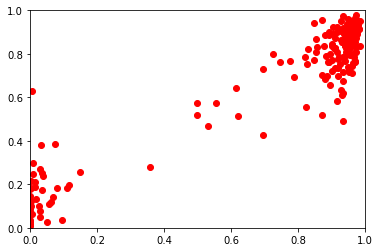

In [35]:
import matplotlib.pyplot as plt
plt.plot(corr_A, corr_C, 'ro')
plt.axis([0, 1, 0, 1])
plt.show()